# VARモデルの構築

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa import stattools
from statsmodels.tsa.api import VAR
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

In [3]:
result_dir_path = Path('result')
if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)

## データの取得

In [4]:
macro_data = sm.datasets.macrodata.load_pandas().data

In [5]:
macro_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


## データの確認

In [6]:
macro_data['year'] = macro_data['year'].astype(int)

macro_data.index = pd.date_range(
    str(macro_data['year'].min()), 
    periods=len(macro_data), 
    freq='Q'
)
target_data = macro_data[['realgdp', 'realcons', 'realinv']]

### グラフによる傾向把握

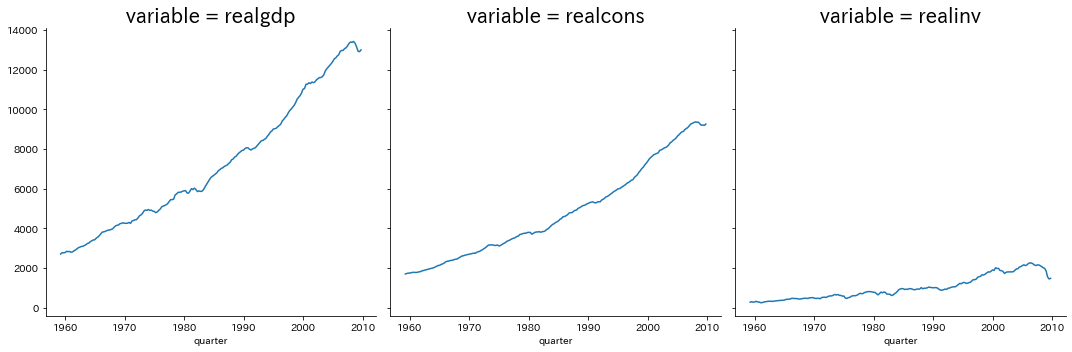

In [7]:
plot_data = target_data.stack()
plot_data = plot_data.reset_index()
plot_data.columns = ['quarter', 'variable', 'value']

g = sns.relplot(
    data=plot_data,
    x='quarter',
    y='value',
    col='variable',
    kind='line'
)
g.set_axis_labels('quarter', '').set_titles(size=20).tight_layout()
g.savefig(result_dir_path.joinpath('macro_data_plot.png'))
g

### 単位根の確認

In [8]:
adf = stattools.adfuller(target_data['realgdp'], regression='ctt')
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
))

t値 : -2.23, p値 : 71.5%
データ数 : 190, 使用されたラグ数 : 12
検定統計量における棄却値 : 1%=-4.43, 5%=-3.86, 10%=-3.57


In [9]:
adf = stattools.adfuller(target_data['realcons'], regression='ctt')
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
))

t値 : -3.01, p値 : 29.1%
データ数 : 199, 使用されたラグ数 : 3
検定統計量における棄却値 : 1%=-4.43, 5%=-3.86, 10%=-3.57


In [10]:
adf = stattools.adfuller(target_data['realinv'], regression='ctt')
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
))

t値 : -1.63, p値 : 92.3%
データ数 : 199, 使用されたラグ数 : 3
検定統計量における棄却値 : 1%=-4.43, 5%=-3.86, 10%=-3.57


p値が5%以上であり、3変数すべてが単位根であるという仮説を棄却できない

## 1次の階差

In [11]:
target_data_diff = target_data.diff().dropna()

### グラフによる傾向把握

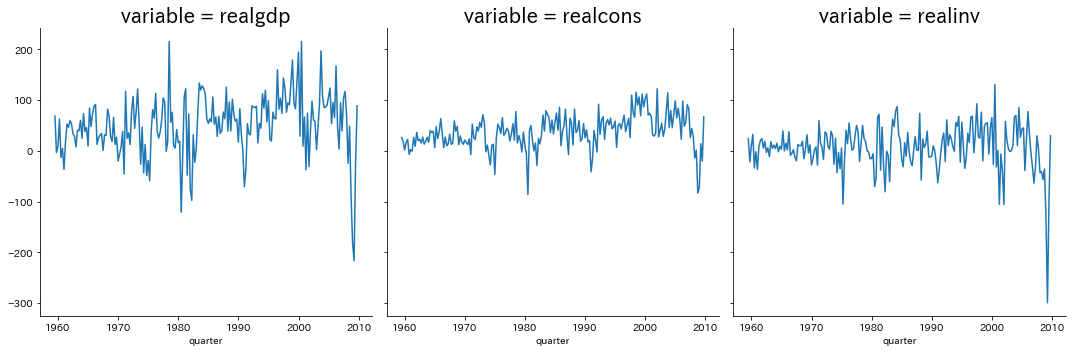

In [12]:
plot_data = target_data_diff.stack()
plot_data = plot_data.reset_index()
plot_data.columns = ['quarter', 'variable', 'value']

g = sns.relplot(
    data=plot_data,
    x='quarter',
    y='value',
    col='variable',
    kind='line'
)
g.set_axis_labels('quarter', '').set_titles(size=20).tight_layout()
g.savefig(result_dir_path.joinpath('macro_data_diff_plot.png'))
g

グラフを見ると、周期性があることがわかり、１次の階差をることでトレンドが消失している事がわかる

### 単位根の確認

In [13]:
adf = stattools.adfuller(target_data_diff['realgdp'], regression='ctt')
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
))

t値 : -4.26, p値 : 1.4%
データ数 : 190, 使用されたラグ数 : 11
検定統計量における棄却値 : 1%=-4.43, 5%=-3.86, 10%=-3.57


In [14]:
adf = stattools.adfuller(target_data_diff['realcons'], regression='ctt')
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
))

t値 : -4.66, p値 : 0.4%
データ数 : 198, 使用されたラグ数 : 3
検定統計量における棄却値 : 1%=-4.43, 5%=-3.86, 10%=-3.57


In [15]:
adf = stattools.adfuller(target_data_diff['realinv'], regression='ctt')
print('t値 : {:.2f}, p値 : {:.1f}%'.format(adf[0], adf[1]*100))
print('データ数 : {}, 使用されたラグ数 : {}'.format(adf[3], adf[2]))
print('検定統計量における棄却値 : 1%={:.2f}, 5%={:.2f}, 10%={:.2f}'.format(
    adf[4]['1%'], adf[4]['5%'], adf[4]['10%']
))

t値 : -10.37, p値 : 0.0%
データ数 : 201, 使用されたラグ数 : 0
検定統計量における棄却値 : 1%=-4.43, 5%=-3.86, 10%=-3.57


p値を見ると、どれも5%を切っており、単位根であるという仮説は棄却できる

## VARモデルの構築

In [16]:
learning_data = target_data.diff().dropna()

model = VAR(learning_data)

In [17]:
model.select_order(15).summary()

,AIC,BIC,FPE,HQIC
0,21.03,21.08,1.358e+09,21.05
1,20.39,20.60*,7.159e+08,20.47
2,20.37,20.73,7.031e+08,20.52
3,20.26*,20.78,6.282e+08*,20.47*
4,20.30,20.97,6.544e+08,20.57
5,20.32,21.15,6.694e+08,20.66
6,20.34,21.32,6.801e+08,20.73
7,20.37,21.51,7.070e+08,20.84
8,20.39,21.68,7.180e+08,20.91
9,20.39,21.85,7.251e+08,20.98


In [18]:
model_result = model.fit(maxlags=15, ic='aic')
model_result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Oct, 2020
Time:                     22:30:35
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    20.6099
Nobs:                     199.000    HQIC:                   20.3144
Log likelihood:          -2818.40    FPE:                5.43599e+08
AIC:                      20.1135    Det(Omega_mle):     4.69244e+08
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              12.638159         7.157543            1.766           0.077
L1.realgdp         -0.393119         0.151899           -2.588           0.010
L1.realcons         1.173272         0.192878            6.083    

### VARモデルの誤差自己相関係数

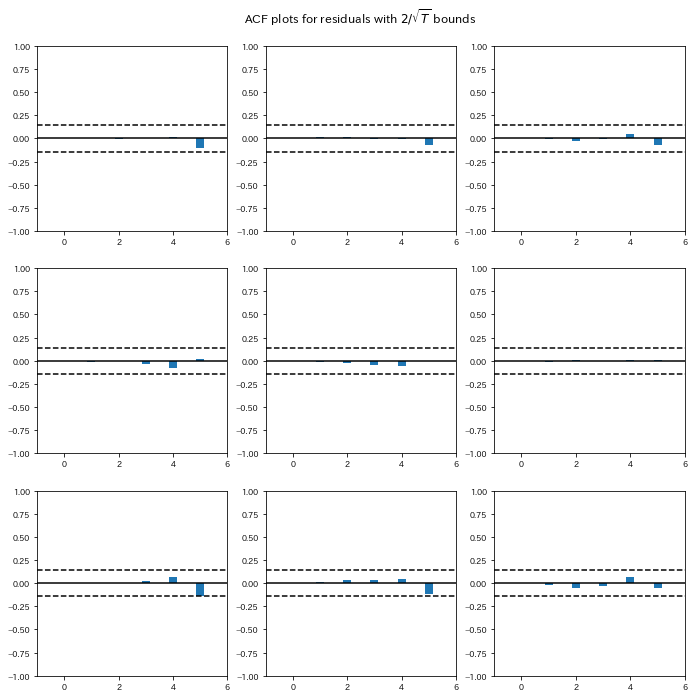

In [19]:
model_result.plot_acorr(nlags=5)
plt.savefig(result_dir_path.joinpath('micro_data_acorr.png'))

### VARモデルを使った予測

In [ ]:
steps = 20
result = model_result.forecast(model_result.endog, steps=steps)

fig = plt.figure(i, figsize=(8, 8))
for i, variable_name in enumerate(['realgdp', 'realcons', 'realinv']):
    
    ax = fig.add_subplot(3, 1, i+1)
    y = model_result.endog[:, i]
    ax.plot(
        np.arange(len(y)),
        y
    )
    ax.plot(
        np.arange(len(y), len(y)+steps),
        result[:, i]
    )
    ax.set_title(variable_name, size=15)
    
fig.tight_layout()
plt.savefig(result_dir_path.joinpath('micro_data_predict.png'))